<a href="https://colab.research.google.com/github/BoKna031/AnimeRecommendationSystem/blob/master/ARSCollaborative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os

In [ ]:
DATASET_FOLDER = os.sep + 'content'+ os.sep +'drive'+ os.sep +'MyDrive'+ os.sep +'Colab Notebooks'+ os.sep +'dataset'
GENERATED_FOLDER = DATASET_FOLDER + os.sep + 'generated'

RATING_CSV_PATH = GENERATED_FOLDER + os.sep + 'rating.csv'
ANIME_CSV_PATH = GENERATED_FOLDER + os.sep + 'anime.csv'
ANIME_SERIES_CSV_PATH = GENERATED_FOLDER + os.sep + 'anime_series.csv'
rating_df = pd.read_csv(RATING_CSV_PATH)
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
rating_df.min()

user_id     1
anime_id    1
rating     -1
dtype: int64

According to the description of the dataset from kaggle, the rating column has a value of -1 if the user watched the anime but did not rate it. Those record should be deleted

In [ ]:
not_rated_anime_index = rating_df[(rating_df['rating'] == -1)].index
rating_df = rating_df.drop(not_rated_anime_index)
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6266296 entries, 47 to 7712177
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 191.2 MB


In [ ]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [ ]:
rating_df.max()

user_id     73516
anime_id    34475
rating         10
dtype: int64

# Visualization of rating data

Idea is that we will try to split all ratings into training and test datasets.
We will need to create user-item matrix with those records.
Problem is that there are some animes with low number of ratings, and we can avoid those records in training set. That scenario will have impact on dimension of matrix and then we cound't do testing

In [ ]:
rating_slice_df = rating_df

Count how many votes have every single anime.
 
*anime_counts* is Series that for *index* contains *anime_id* and for values number of ratings that anime have

In [ ]:
anime_counts = rating_slice_df['anime_id'].value_counts()

In [ ]:
anime_counts = anime_counts.sort_values()
anime_counts

8749         1
24269        1
33907        1
33908        1
22241        1
         ...  
6547     23565
1575     24126
16498    25290
11757    26310
1535     34226
Name: anime_id, Length: 8826, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Num of votes')

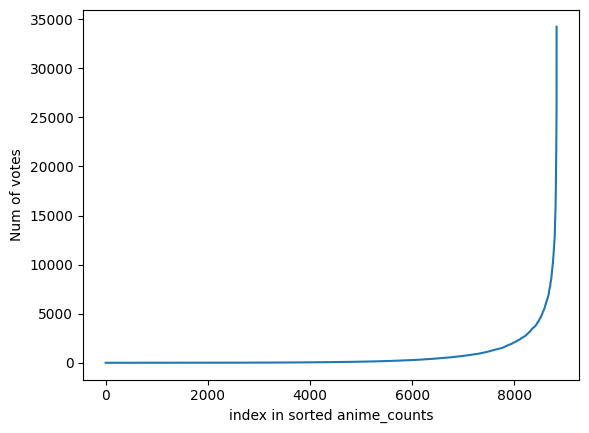

In [ ]:
plt.plot(anime_counts.values)
plt.xlabel("index in sorted anime_counts")
plt.ylabel("Num of votes")

From graph we can see that most of animes have low amount of votes.

Now we will group animes with same amout of votes to create better representation of information about vote frequency.

That information will be stored into *grouped_anime_counts* [number of votes, number of anime with that amount of votes]

In [ ]:
grouped_anime_counts = anime_counts.groupby(anime_counts).size()
grouped_anime_counts = grouped_anime_counts.sort_index()
grouped_anime_counts

anime_id
1        800
2        482
3        293
4        226
5        145
        ... 
23565      1
24126      1
25290      1
26310      1
34226      1
Name: anime_id, Length: 2076, dtype: int64

In [ ]:
grouped_anime_counts[:20]

anime_id
1     800
2     482
3     293
4     226
5     145
6     151
7     120
8     106
9      90
10    105
11     64
12     64
13     70
14     79
15     77
16     61
17     58
18     43
19     47
20     41
Name: anime_id, dtype: int64

From print above we can see that most of animes have less than 10 votes.
Those animes will be removed from dataframe because we will drasticly remove dimensionality of user-item matrix and minimize chances for losing anime in training set.

In [ ]:
anime_counts = anime_counts[anime_counts > 10]
anime_counts

4509        11
31634       11
32481       11
5237        11
18425       11
         ...  
6547     23565
1575     24126
16498    25290
11757    26310
1535     34226
Name: anime_id, Length: 6308, dtype: int64

In [ ]:
rating_slice_df

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7712173,73515,16512,7
7712174,73515,17187,9
7712175,73515,22145,10
7712176,73516,790,9


In [ ]:
rating_slice_df = rating_slice_df[rating_slice_df['anime_id'].isin(anime_counts)]
rating_slice_df

,user_id,anime_id,rating
156,3,20,8
157,3,154,6
158,3,170,9
159,3,199,10
160,3,225,9
...,...,...,...
7712078,73515,2759,9
7712084,73515,3231,8
7712090,73515,3594,9
7712103,73515,4975,7


We drastically reduced the amount of data we will work with from rating dataframe :)

# User-Item matrix

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095418 sha256=2f85b72a20177a3b64bc4ce2afb1813232fd6419a6612255632dcfd198179f42
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Reader
from surprise import Dataset
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_slice_df[["user_id", "anime_id", "rating"]], reader)

In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate
cross_validate(SVD(), data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2382  1.2335  1.2336  1.2366  1.2367  1.2357  0.0019  
MAE (testset)     0.9343  0.9320  0.9324  0.9338  0.9334  0.9332  0.0009  
Fit time          35.28   25.81   28.71   26.89   27.40   28.82   3.36    
Test time         5.44    6.05    5.67    4.96    5.22    5.47    0.37    


{'test_rmse': array([1.23822835, 1.23352648, 1.23361477, 1.23664714, 1.23670919]),
 'test_mae': array([0.93428205, 0.93197474, 0.93236945, 0.93377458, 0.93340116]),
 'fit_time': (35.27725267410278,
  25.811567068099976,
  28.713794946670532,
  26.891103982925415,
  27.40429711341858),
 'test_time': (5.4375104904174805,
  6.048529863357544,
  5.668503046035767,
  4.962202787399292,
  5.223474740982056)}

In [ ]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.25)

In [ ]:
from surprise import SVD
algo = SVD()
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)

In [ ]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 1.2434


1.243352042030407

# Recommendations for specific users

recommendation of N anime that the user have never watched

In [ ]:
number_of_recommendation = 25

In [ ]:
rating_counts = rating_slice_df['user_id'].value_counts().sort_values()
print(rating_counts)

56263      1
14965      1
12697      1
57939      1
73094      1
        ... 
45659    622
11398    627
7345     682
51806    686
42635    913
Name: user_id, Length: 63135, dtype: int64


Let's show how often users vote

Text(0, 0.5, 'Num of votes')

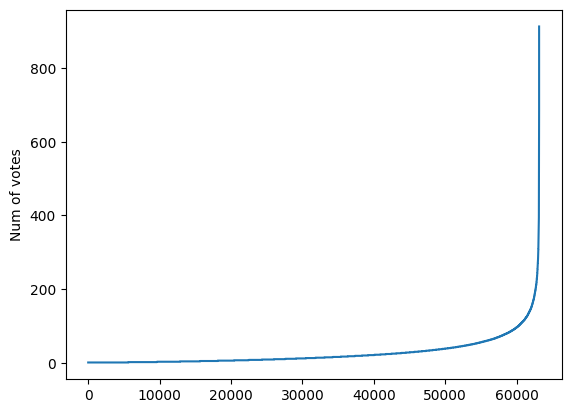

In [ ]:
plt.plot(rating_counts.values)
plt.ylabel("Num of votes")

In [ ]:
grouped_user_counts = rating_counts.groupby(rating_counts).size()
grouped_user_counts = grouped_user_counts.sort_index()
grouped_user_counts

user_id
1      5634
2      3991
3      3235
4      2818
5      2440
       ... 
622       1
627       1
682       1
686       1
913       1
Name: user_id, Length: 383, dtype: int64

In [ ]:
rating_counts.loc[rating_counts.between(100,500)]

28040    100
36610    100
37870    100
24822    100
25262    100
        ... 
59643    474
51693    474
30597    475
6384     481
60743    494
Name: user_id, Length: 2918, dtype: int64

Selection of different group of users 

In [ ]:
points = [0, 10, 50, 150, 350, 700, 1000]
test_users = []
for i, p in enumerate(points[:-1]):
  start, end = p, points[i+1]
  test_users.append(rating_counts.loc[rating_counts.between(start,end)].sample())
test_users

[69336    3
 Name: user_id, dtype: int64,
 12466    17
 Name: user_id, dtype: int64,
 31702    51
 Name: user_id, dtype: int64,
 51240    221
 Name: user_id, dtype: int64,
 23257    379
 Name: user_id, dtype: int64,
 42635    913
 Name: user_id, dtype: int64]

In [ ]:
user_num = 0
user_id = test_users[user_num].index[0]

In [ ]:
anime_df = pd.read_csv(ANIME_CSV_PATH)
anime_ids = anime_df['MAL_ID']
watched_anime = rating_slice_df[(rating_slice_df['user_id'] == user_id)]


In [ ]:
mask = anime_ids.isin(watched_anime['anime_id'])

In [ ]:
unwatched_anime = anime_ids.loc[~mask]

In [ ]:
unwatched_anime

0            1
1            5
2            6
3            7
4            8
         ...  
16146    48481
16147    48483
16148    48488
16149    48491
16150    48492
Name: MAL_ID, Length: 16148, dtype: int64

In [ ]:
watched_anime['anime_id']

7335011    121
7335012    430
7335013    889
Name: anime_id, dtype: int64

In [ ]:
predictions = []
for anime_id in unwatched_anime:
  predictions.append(algo.predict(user_id, anime_id ))

In [ ]:
sorted_by_rating = sorted(predictions, key= lambda x: x.est, reverse = True)



In [ ]:
recommendation_df = pd.DataFrame(columns = ['MAL_ID', 'Name', 'Estimation'])
anime_groups_df = pd.read_csv(ANIME_SERIES_CSV_PATH, index_col=0)
rec_group = set()
for pred in sorted_by_rating[0:number_of_recommendation]:
  rec_anime_id = pred.iid
  rec_est = pred.est
  new_rec = anime_df.loc[anime_df['MAL_ID'] == rec_anime_id]
  new_rec = new_rec[['MAL_ID', 'Name']].copy()
  new_rec['Estimation'] = rec_est
  anime_group = anime_groups_df.loc[anime_groups_df['MAL_ID'] == rec_anime_id]
  if anime_group.empty == False:
    if int(anime_group['Group']) in rec_group:
      print('Pronasao sam jednog iz grupe ', int(anime_group['Group']), ' sa nazivom ', anime_group['Name'])
      continue
    else:
      rec_group.add(int(anime_group['Group']))
  recommendation_df = pd.concat([recommendation_df, new_rec], axis=0, ignore_index = True)





In [ ]:
anime_groups_df.loc[anime_groups_df['Group'] == 5]

,Name,MAL_ID,Group
17,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsui...,44,5
18,Rurouni Kenshin: Meiji Kenkaku Romantan,45,5
19,Rurouni Kenshin: Meiji Kenkaku Romantan - Shin...,11441,5
20,Rurouni Kenshin: Meiji Kenkaku Romantan - Seis...,401,5


In [ ]:
recommendation_df

,MAL_ID,Name,Estimation
0,820,Ginga Eiyuu Densetsu,9.594884
1,199,Sen to Chihiro no Kamikakushi,9.517046
2,918,Gintama,9.444418
3,6594,Katanagatari,9.254977
4,431,Howl no Ugoku Shiro,9.215057
5,11979,Mahou Shoujo Madoka★Magica Movie 2: Eien no Mo...,9.085566
6,263,Hajime no Ippo,9.032332
7,164,Mononoke Hime,9.021596
8,1453,Maison Ikkoku,8.996126
9,232,Cardcaptor Sakura,8.981206


In [ ]:
RECOMMENDATION_CSV_PATH = GENERATED_FOLDER + os.sep + 'recommendation.csv'
recommendation_df.to_csv(RECOMMENDATION_CSV_PATH)

In [ ]:
recommendation_df

,MAL_ID,Name,Estimation
0,820,Ginga Eiyuu Densetsu,9.594884
1,199,Sen to Chihiro no Kamikakushi,9.517046
2,918,Gintama,9.444418
3,6594,Katanagatari,9.254977
4,431,Howl no Ugoku Shiro,9.215057
5,11979,Mahou Shoujo Madoka★Magica Movie 2: Eien no Mo...,9.085566
6,263,Hajime no Ippo,9.032332
7,164,Mononoke Hime,9.021596
8,1453,Maison Ikkoku,8.996126
9,232,Cardcaptor Sakura,8.981206
